# Importation des modules

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from skimage import data

from PIL.Image import *

from imageio import imread
import glob
from tqdm import tnrange
from tqdm.notebook import tqdm_notebook
import tqdm
import torch
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torchvision.utils import save_image

import multiprocessing
import time

In [2]:
torch.cuda.is_available()

True

# Création du train_set et test_set


## Chargement du dataset

In [3]:
size = 120

In [4]:
deep = 3

In [5]:
def image_to_numpy(image) :
    n = len(image)
    image_bis = []
    for i in range (n) :
        image_bis.append([])
        for j in range(n) :
            image_bis[i].append(image[i][j][0])
    return np.array(image_bis)

In [6]:
list_images = []
list_labels = []

list_path = set()

path_imgs = "trans100/"

def select_unique_imgs():
    for image_path in tqdm_notebook(glob.glob(path_imgs + "*.png")):
        label = image_path.find('l')
        couche = image_path.find('c')
        id_image = image_path[:couche]
        label_image = int(image_path[label+1:couche])
        list_path.add((id_image, label_image))



def load_pictures(data_files):
    with multiprocessing.Pool() as p :
        res = list(tqdm.tqdm(p.imap(load_image3.load_img_from_path, data_files), total=len(data_files)))
    for lot_lab, lot_img in tqdm.tqdm(res, total=len(res)):
        list_images.append(lot_img)
        list_labels.append(lot_lab)

In [7]:
select_unique_imgs()

In [8]:
import load_image3


if __name__ ==  '__main__' : 
    load_pictures(list_path)

100%|█████████████████████████████████████████████████████████████████████████| 8283/8283 [00:00<00:00, 1654589.70it/s]


## Renumérotation des labels

nombre de classes :  93
répartition des labels :


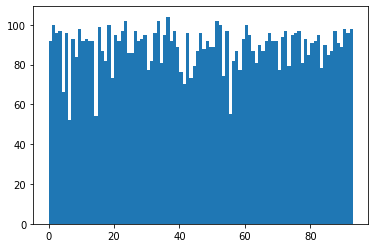

In [9]:
num_label = np.histogram(list_labels, bins=range(max(list_labels)+2))[0]
nouv_label = [-1]*(max(list_labels)+2)
compteur = 0
for i in range(max(list_labels)+1) :
    if num_label[i]>0 :
        nouv_label[i]=compteur
        compteur+=1
        
label_max = max(nouv_label)

num_classes = label_max+1

print("nombre de classes : ", num_classes)

nouv_list_labels = []
for i in range(len(list_labels)) :
    nouv_list_labels.append(nouv_label[list_labels[i]])

plt.hist(nouv_list_labels, bins=range(label_max +2))

print("répartition des labels :")

## Mélange et transformation pytorch du dataset en train_set et test_set

In [10]:
def shuffle_in_unison(list_images, list_labels):
    assert len(list_images) == len(list_labels)
    shuffled_list_images = np.empty(list_images.shape, dtype=list_images.dtype)
    shuffled_list_labels = np.empty(list_labels.shape, dtype=list_labels.dtype)
    permutation = np.random.permutation(len(list_images))
    for old_index, new_index in enumerate(permutation):
        shuffled_list_images[new_index] = list_images[old_index]
        shuffled_list_labels[new_index] = list_labels[old_index]
    return shuffled_list_images, shuffled_list_labels

In [11]:
def list_to_torch(list_images, list_labels) :
    n = len(list_images)
    
    torch_images=np.array([np.asarray(data) for data in list_images])
    torch_labels=np.array(list_labels)
    
    torch_images, torch_labels=shuffle_in_unison(torch_images, torch_labels)
    
    torch_images = torch.from_numpy(torch_images).cuda()
    torch_labels = torch.from_numpy(torch_labels).cuda()
    
    train_set = torch.utils.data.TensorDataset(torch_images[:int(0.8*n)],torch_labels[:int(0.8*n)])
    test_set = torch.utils.data.TensorDataset(torch_images[int(0.8*n):],torch_labels[int(0.8*n):])
    
    return train_set, test_set

In [12]:
train_set, test_set = list_to_torch(list_images, nouv_list_labels)

# Définition et entraînement du réseau de neurones

In [13]:
def train_epoch(net, train_set, opt, criterion, batch_size):
    net.train()
    trainloader = torch.utils.data.DataLoader(train_set, batch_size)
    for x_batch, y_batch in trainloader :
        opt.zero_grad()
        # Forward
        y_pred = net(x_batch.float()).logits
        y_batch = y_batch.long()
        # Compute diff
        loss = criterion(y_pred, y_batch) #car le GoogleNet tout fait renvoyé un triplet
        # Compute gradients
        loss.backward()
        # update weights
        opt.step()

def accuracy(net, dataset):
    net.eval()
    correct = 0
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=1)
    for x_batch, y_batch in trainloader :
        y_pred = net(x_batch.float())
        y_pred = torch.argmax(y_pred).int()
        if int(y_pred)==int(y_batch[0]) :
            correct+=1
    return correct/len(dataset)

In [14]:
import torchvision.models as models

In [15]:
ggnet_trained = models.googlenet(pretrained=True)

In [16]:
net = models.googlenet(num_classes = num_classes).cuda()

C:\Users\stani\anaconda3\envs\modal\lib\site-packages\torchvision\models\googlenet.py:73: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


In [17]:
params_trained = ggnet_trained.named_parameters()
params = net.named_parameters()

dict_params_trained = dict(params_trained)
dict_params = dict(params)


for name in dict_params :
    if name[0:2]=="fc" or name[0:3]=="aux" :
        break    
    dict_params[name].data.copy_(dict_params_trained[name])
    dict_params[name].data.requires_grad = False

C:\Users\stani\anaconda3\envs\modal\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  from ipykernel import kernelapp as app


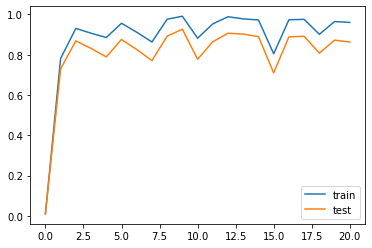

accuracy : 0.8630054315027158
temps d'exécution : 40.81112443208694 min


In [18]:
debut = time.time()

epochs = 20
criterion = nn.CrossEntropyLoss()

opt = torch.optim.Adam(net.parameters(),lr=1e-3,betas=(0.9, 0.999),eps=1e-08)


preci_train = []
preci_test = []

preci_train.append(accuracy(net, train_set))
preci_test.append(accuracy(net, test_set))

for i in tnrange(epochs) :
    train_epoch(net, train_set, opt, criterion, batch_size=25)
    preci_train.append(accuracy(net, train_set))
    preci_test.append(accuracy(net, test_set))

plt.plot(range(len(preci_train)), preci_train, label = "train")
plt.plot(range(len(preci_test)), preci_test, label =  "test")
plt.legend()
plt.show()

print("accuracy :", accuracy(net, test_set)) 

fin = time.time()
duree = fin-debut
print("temps d'exécution :", duree/60, "min")